In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import iSDR_cython as ciSDR
np.random.seed(12)

In this notebook, we show an example on how to run eISDR and its old version iSDR that is presented in:
    
    (1) Brahim Belaoucha, Théodore Papadopoulo. Large brain effective network from EEG/MEG data and dMR information. PRNI 2017 – 7th International Workshop on Pattern Recognition in NeuroImaging, Jun 2017, Toronto, Canada.

    (2) Brahim Belaoucha, Mouloud Kachouane, Théodore Papadopoulo. Multivariate Autoregressive Model Constrained by Anatomical Connectivity to Reconstruct Focal Sources. 2016 38th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), Aug 2016, Orlando, United States. 2016.

We show how you can run both using real and synthetic data

# Define sensor and source space

In [2]:
n_t = 200
n_c, n_s = 3,3
np.random.seed(40)
G = np.abs(np.random.normal(0,1,(n_c, n_s)))
J = np.zeros((n_s, n_t))
J[:3, 0] = [10, 0.1, 0]
A = np.array([[0.9,-0.4,0], [0.25, 0.97,0],[0.5,0,0.5]])
for i in range(J.shape[-1]-1):
    J[:3, i+1] = np.dot(A, J[:3, i])

print(A)


[[ 0.9  -0.4   0.  ]
 [ 0.25  0.97  0.  ]
 [ 0.5   0.    0.5 ]]


# Ground truth

(0, 200)

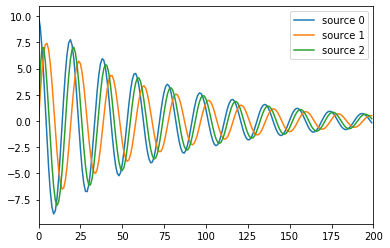

In [3]:
plt.plot(J.T)
plt.legend(['source %s'%s for s in range(n_s)])
plt.xlim(0, n_t)

# Define the structural connectivity

In [4]:
SC = np.array([[1,1,1], [1,1,0],[1,0,1]])
print( SC)

[[1 1 1]
 [1 1 0]
 [1 0 1]]


# Example 1: eiSDR order 1

## Generate EEG/MEG data

In [5]:
m_p = 1
M = np.dot(G, J[:, m_p:])

## Run eiSDR

In [6]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-2, 0.69], verbose=1, old_version=0,
                             normalize_Sstep=True, normalize_Astep=True)
cl.solver(G, M, SC, nbr_iter=10, model_p=1, A=np.eye(n_s), S_tol=1e-3)
R = cl.coef_
cl.xscale

Iteration 0: nbr of active sources 3
Iteration 1: nbr of active sources 3
Stopped at iteration 1 : Change in active set tol 3.0000 > 3.0000  


array([[0.45207599],
       [0.6568646 ],
       [0.00276875]])

## Get eigenvalues of MVAR model

In [7]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.482160,0.000000
eig_1,0.938038,0.313074
eig_2,0.938038,-0.313074


## Plot effective connectivity

Execution time 0.010 sec


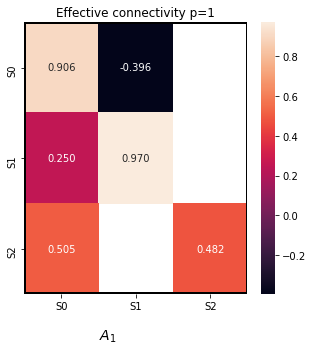

In [17]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

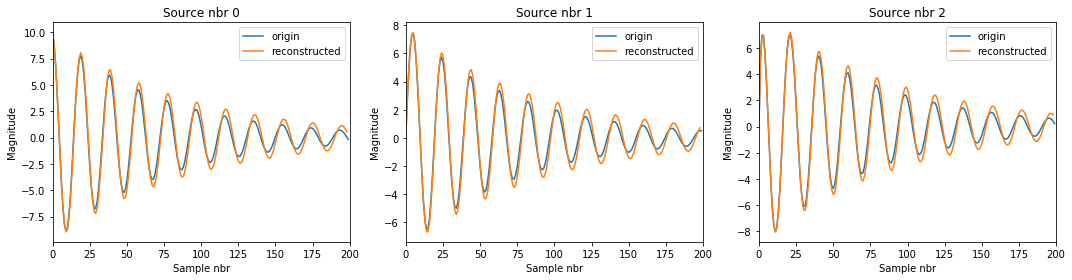

In [18]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p-1:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [19]:
for i in range(m_p, n_t - m_p):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

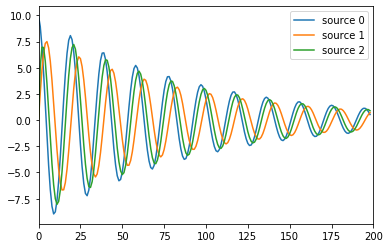

In [20]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Example 2: eiSDR order 3

## Initialize MVAR model

In [21]:
m_p = 3
Atmp = np.zeros((n_s, n_s*m_p))
Atmp[:, -n_s:] = np.eye(n_s)

## Run eiSDR

In [ ]:
cl = ciSDR.linear_model.iSDR(l21_ratio=0.1, la=[1e-2, 1.], verbose=True, old_version=0, normalize_Sstep=True,
                             normalize_Astep=True)
cl.solver(G, M, SC, nbr_iter=10, model_p=m_p, A=Atmp)
R = cl.coef_

## Compute eigenvalues of MVAR model

In [23]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,-0.824389,0.501890
eig_1,-0.824389,-0.501890
eig_2,0.827793,0.506578
eig_3,0.827793,-0.506578
eig_4,-0.002711,0.925117
eig_5,-0.002711,-0.925117
eig_6,-0.659906,0.000000
eig_7,0.359571,0.587963
eig_8,0.359571,-0.587963


## Plot effective connectivity

Execution time 0.538 sec


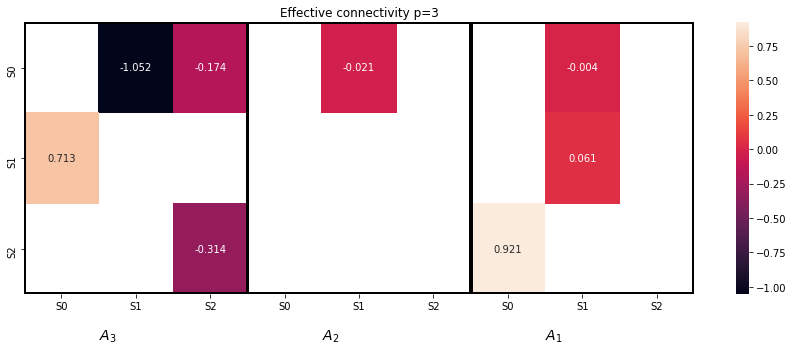

In [24]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstruct the brain activation

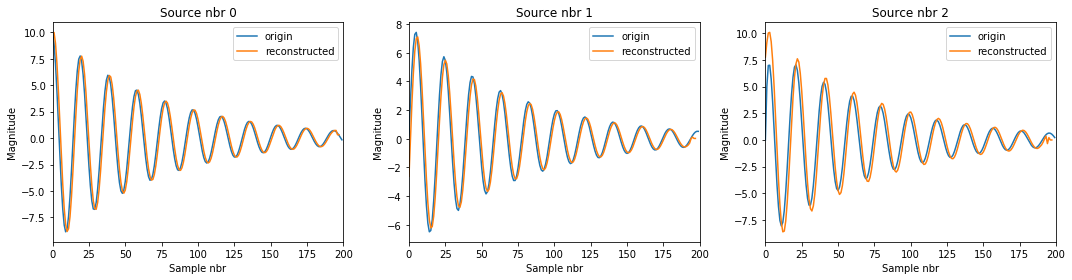

In [25]:
plt.figure(figsize=(15,4))
for i in range(n_s):
    plt.subplot(1,n_s, i+1)
    plt.plot(J[i, :], label='origin')
    if i < R.shape[0]:
        plt.plot(R[i, m_p:], label='reconstructed')
    plt.title('Source nbr %s'%i)
    plt.xlim(0, J.shape[1])
    plt.xlabel('Sample nbr')
    plt.ylabel('Magnitude')
    plt.legend()
plt.tight_layout()

## Reconstruct the brain activation using the estimated MVAR model

In [26]:
for i in range(m_p, R.shape[1]):
    R[:, i] = 0
    x = R.shape[0]
    for j in range(m_p):
        R[:, i] += np.dot(cl.Acoef_[:, j*x:(j+1)*x], R[:, i - m_p + j]) 

(0, 200)

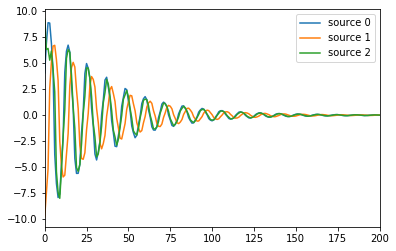

In [27]:
plt.plot(R.T)
plt.legend(['source %s'%s for s in cl.active_set[-1]])
plt.xlim(0, n_t)

# Cross-validation eiSDR:  grid-search

## Load eiSDRcv

In [28]:
from iSDR_cython import linear_model

In [29]:
clf = linear_model.iSDRcv(l21_values=[10**-i for i in range(-1, 6, 1)],
                          la_values=[10**-i for i in range(-1, 5,1)], la_ratio_values=[1, 0.5, 0.75, 0.25],
                          normalize=[0, 1],
                          model_p=[1,2],
                         old_version=False,
                          normalize_Astep=[1, 0],
                          normalize_Sstep=[1, 0]
                         )

## Created random folder

In [30]:
clf.foldername

'/tmp/tmp_1b8fc769-0c88-468d-948d-251aa1b5e938'

## Run grid cross validation

In [ ]:
clf.run(G, M, SC)

## Results

In [32]:
print('Execution time %.3f sec'%clf.time)
df = clf.results

Execution time 17.660 sec


In [33]:
df.Obj.min()

0.006357151299756612

## Parameters resulting to smallest Obj

In [34]:
x  = df[df.Obj == df.Obj.min()]

In [35]:
x

,rms,nbr,S_prior,A_prior_l1,A_prior_l2,ls_reg,la_reg_a,la_reg_r,p,normalize,l21_real,normalize_Astep,normalize_Sstep,Obj
706,0.001782,3,116.26573,3.550936,2.500114,0.00001,0.0001,0.25,1,0,0.000038,0,1,0.006357
974,0.001782,3,116.26573,3.550936,2.500114,0.00001,0.0001,0.25,1,0,0.000038,1,1,0.006357


## Reconstruct with optimal parameters

In [36]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=False, normalize_Astep=x.normalize_Astep.values[0],
                            normalize_Sstep=x.normalize_Sstep.values[0])
cl.solver(G, M, SC, nbr_iter=10, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.coef_

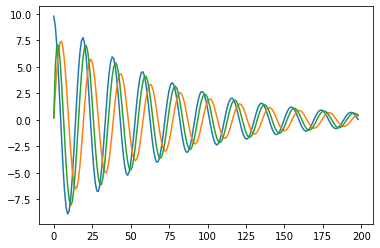

In [37]:
plt.plot(cl.coef_.T)

## Reconstructed effective connectivity

Execution time 0.010 sec


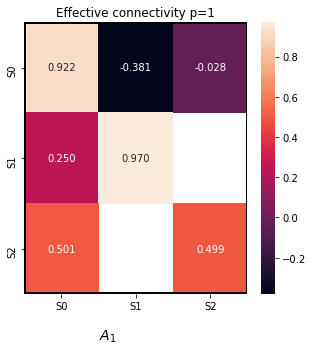

In [38]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

## Reconstructed dynamics

In [39]:
cl.get_phi()
cl.eigs

,real,imag
eig,,
eig_0,0.521861,0.000000
eig_1,0.934929,0.314297
eig_2,0.934929,-0.314297


# Real data

We are using EEG data acquired during famous face recognition task. we should see an activation around 170 ms in the fusiform area

In [40]:
from scipy.io import loadmat

In [41]:
data = loadmat('S1_p1_EEGT800.mat')

In [42]:
fs = 1/np.diff(data['time'])[0][0]

## L1 prior on MVAR

In [47]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-11, 1], verbose=1, old_version=False,
                             normalize_Sstep=False, normalize_Astep=False)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

Iteration 0: nbr of active sources 562
Iteration 1: nbr of active sources 95
Iteration 2: nbr of active sources 57
Iteration 3: nbr of active sources 51
Iteration 4: nbr of active sources 49
Iteration 5: nbr of active sources 48
Iteration 6: nbr of active sources 43
Iteration 7: nbr of active sources 42
Iteration 8: nbr of active sources 41
Iteration 9: nbr of active sources 38
Iteration 10: nbr of active sources 37
Iteration 11: nbr of active sources 35
Stopped at iteration 11 : Change in active set tol 35.0000 > 35.0000  


### Brain reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

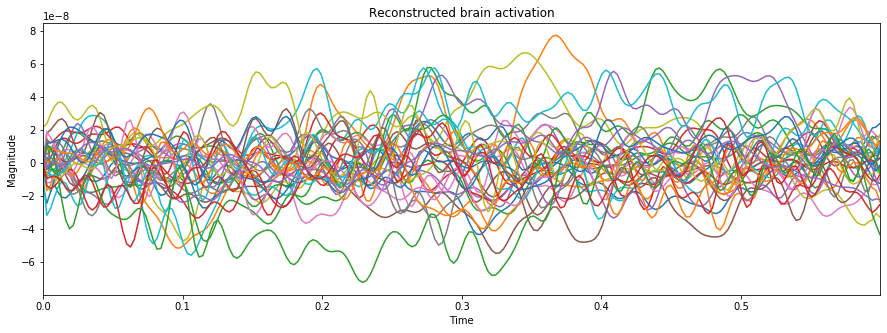

In [48]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (Sparse)

Execution time 75.620 sec


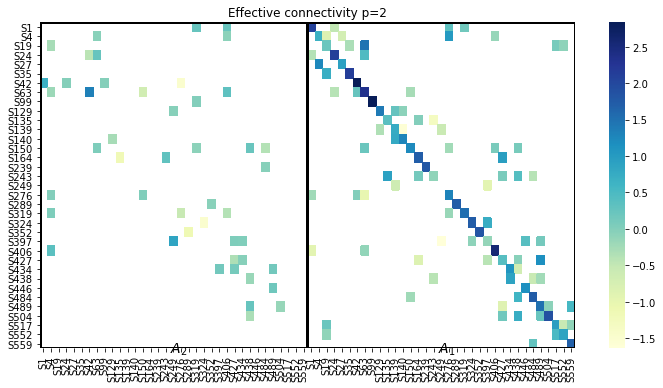

In [50]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective(fig_size=6, annot=False, cmap="YlGnBu")

### Left fusiform area

In [51]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

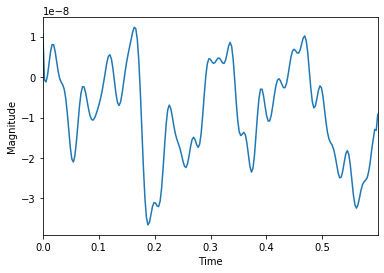

In [52]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

## L2 prior on MVAR

In [ ]:
cl = ciSDR.linear_model.iSDR(l21_ratio=5, la=[1e-12, 0], verbose=1, old_version=False, normalize_Sstep=False)
cl.solver(data['G'], data['M']*1e12, data['SC'].astype(int), model_p=2, A=None, normalize=False)
R = cl.coef_*1e-12

### Brain activation reconstruction

Text(0.5, 1.0, 'Reconstructed brain activation')

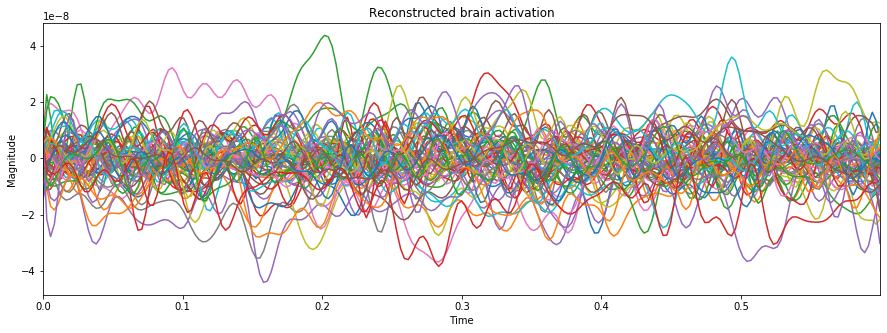

In [54]:
time = [i/fs for i in range(R.shape[1])]
plt.figure(figsize=(15,5))
plt.plot(time, R.T);
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Reconstructed brain activation')

### Effective connectivity (less sparse) 

Execution time 851.388 sec


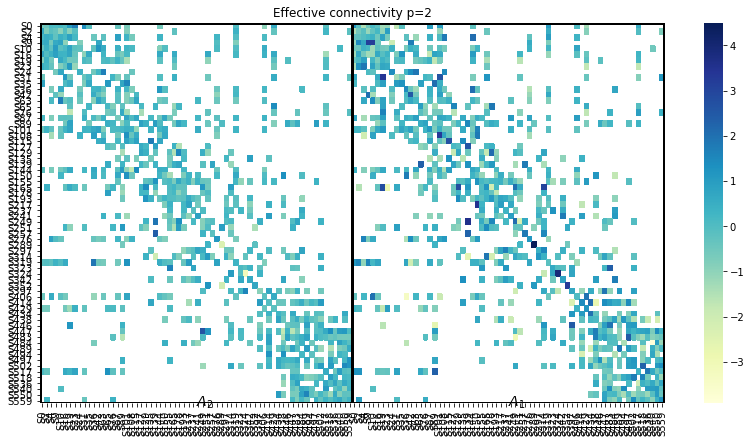

In [55]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective(fig_size=7, annot=False, cmap="YlGnBu")

### Left fusiform area

In [56]:
ix = np.where(cl.active_set[-1] == 42)[0][0]

Text(0, 0.5, 'Magnitude')

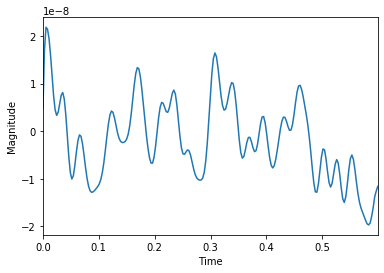

In [57]:
plt.plot(time, 1e-12*cl.coef_[ix, :])
plt.xlim([time[0], time[-1]])
plt.xlabel('Time')
plt.ylabel('Magnitude')

# Example on how to run iSDR

You can use the iSDR EEG/MEG source reconstruction by setting the 'old_version' to True

In [58]:
cl = ciSDR.linear_model.iSDR(l21_ratio=x.ls_reg.values[0], la=[x.la_reg_a.values[0], x.la_reg_r.values[0]],
                             old_version=True, normalize_Sstep=False)
cl.solver(G, M, SC, model_p=x.p.values[0], A=np.eye(n_s))
R = cl.coef_

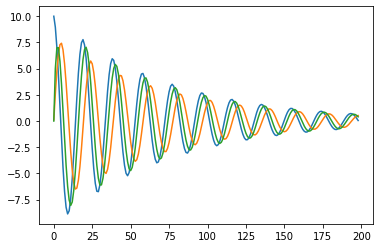

In [59]:
plt.plot(R.T)

In [60]:
cl.get_phi()

Execution time 0.007 sec


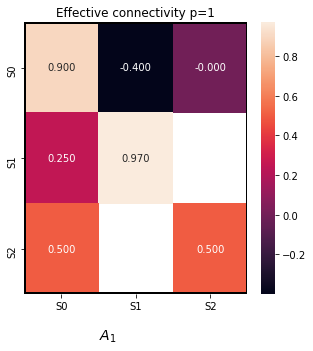

In [63]:
print('Execution time %.3f sec'%cl.time)
cl.plot_effective()

In [64]:
cl.la

[0.0, 0.0]

In [65]:
cl.eigs

,real,imag
eig,,
eig_0,0.499996,0.000000
eig_1,0.935000,0.314285
eig_2,0.935000,-0.314285
